In [28]:
import numpy as np
import xarray as xr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd
import os
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import areamean_dhq as areamean
import copy
import dyl_function_slope as dyl
import cmaps
import matplotlib as mpl
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Helvetica"]
ccmap = cmaps.cmp_b2r

In [29]:
def calculate_zonal_stats(data):
    # Assuming 'data' is a 2D array with shape (lat, lon)
    zonal_mean = np.nanmean(data, axis=1)  # Zonal mean
    zonal_std = np.nanstd(data, axis=1)  # Zonal standard deviation
    return zonal_mean, zonal_std

In [30]:
# 绘制观测趋势图并添加显著性阴影
def plot_trend_and_significance(axes, data, trend,  title, sequence, exp, levels, levels2, ccmap, p_values=None,climatology=None,hzl=False):
    # Set the global extent
    # ax.projection(ccrs.Robinson())
    time, lat, lon = data.dims
    ax = fig.add_axes(axes, projection=ccrs.Robinson())
    ax.set_global()
    ax.set_aspect(1.25)

    if hzl:
        # ======= 添加20-40°N紫色横线 =======
        for lats in [20, 40]:
            ax.plot([-180, 180], [lats, lats], color='magenta', linewidth=1.2, linestyle='-',
                    transform=ccrs.PlateCarree(), zorder=4,alpha=0.8)

    # 为数据添加周期性点
    trend_cyclic, lon_cyclic = add_cyclic_point(trend, coord=data[lon])

    # Plot the trend
    cf = ax.contourf(lon_cyclic, data[lat], trend_cyclic, levels=levels, cmap=ccmap, extend='both',
                     transform=ccrs.PlateCarree())
    ax.coastlines(lw=0.5)

    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}

    # Plot the significance
    if p_values is not None:
        # 确保一致性掩码也添加周期性点
        consistency_mask_cyclic, _ = add_cyclic_point(p_values, coord=data[lon])
        significance = np.ma.masked_where(p_values >= 0.05, p_values)
        cc = ax.contourf(data[lon], data[lat], significance, hatches=['...'], colors='none', transform=ccrs.PlateCarree())
        if hasattr(cc, 'collections'):
            collections = cc.collections
        else:
            collections = [cc]
        # 设置 hatch 样式
        for collection in collections:
            collection.set_edgecolor('grey')
            collection.set_linewidth(0)

    if climatology is not None:
        clim_cyclic, _ = add_cyclic_point(climatology, coord=data[lon])
        c2 = ax.contour(lon_cyclic, data[lat], clim_cyclic, levels=levels2, colors='m', alpha=0.9, linewidths=.5,
                        transform=ccrs.PlateCarree())
        ax.clabel(c2, colors='k', inline=True, fontsize=6)
    # Set the title
    #ax.set_title(title, fontsize=7)
    ax.text(-0.05, 1.1, sequence, transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    ax.text(0.7, 1.1, exp, transform=ax.transAxes, fontsize=7, va='top', ha='left')

    return cf

In [31]:
# 绘制模式的趋势图并添加显著性阴影
def plot_trend_and_significance_ssp(axes, data, trend, p_values, title, sequence, exp, levels, levels2,
                                    ccmap, climatology=None, hzl=False):
    ax = fig.add_axes(axes, projection=ccrs.Robinson())
    ax.set_global()
    ax.set_aspect(1.25)

    if hzl:
        # ======= 添加20-40°N紫色横线 =======
        for lats in [20, 40]:
            ax.plot([-180, 180], [lats, lats], color='magenta', linewidth=1.2, linestyle='-',
                    transform=ccrs.PlateCarree(), zorder=4, alpha=0.8)
    # 为数据添加周期性点
    trend_cyclic, lon_cyclic = add_cyclic_point(trend, coord=data['lon'])
    # 确保一致性掩码也添加周期性点
    consistency_mask_cyclic, _ = add_cyclic_point(p_values, coord=data['lon'])
    # Plot the trend
    cf = ax.contourf(lon_cyclic, data['lat'], trend_cyclic, levels=levels, cmap=ccmap, extend='both',
                     transform=ccrs.PlateCarree())
    ax.coastlines(lw=0.5)
    # Add gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xlabel_style = {'size': 7}
    gl.ylabel_style = {'size': 7}
    # Plot the significance
    significance = np.ma.masked_where(p_values >= 0.05, p_values)
    cc = ax.contourf(data['lon'], data['lat'], significance, hatches=['...'], colors='none',
                     transform=ccrs.PlateCarree())

    if hasattr(cc, 'collections'):
        collections = cc.collections
    else:
        collections = [cc]
    # 设置 hatch 样式
    for collection in collections:
        collection.set_edgecolor('grey')
        collection.set_linewidth(0)

    if climatology:
        clim_cyclic, _ = add_cyclic_point(climatology, coord=data['lon'])
        c2 = ax.contour(lon_cyclic, data['lat'], clim_cyclic, levels=levels2, colors='m', alpha=1, linewidths=.5,
                        transform=ccrs.PlateCarree())
        ax.clabel(c2, colors='k', inline=True, fontsize=6)
    # Set the title
    #ax.set_title(title, fontsize=7)
    ax.text(-0.05, 1.1, sequence, transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    ax.text(.7, 1.1, exp, transform=ax.transAxes, fontsize=7, va='top', ha='left')
    return cf

In [32]:
# 绘制纬向平均的急流抬升趋势
def plot_zonmean_diff(ax, trend_zonmean, std_diff,linesty, lat, title, sequence, xlim):
    # 计算100hPa和200hPa的纬向风差值
    latitudes = lat.values
    # 绘制集合平均
    ax.plot(trend_zonmean, latitudes, 'k',linestyle=linesty, linewidth=1)
    # 填充模型间一倍标准差
    ax.fill_betweenx(latitudes, trend_zonmean - std_diff, trend_zonmean + std_diff, color='grey', alpha=0.2)
    ax.fill_between(xlim, -20, -40, color='dodgerblue', alpha=0.05)
    ax.fill_between(xlim, 20, 40, color='dodgerblue', alpha=0.05)
    # 绘制竖直0刻度线
    ax.axvline(0, color='grey', linewidth=.5)
    # 设置横纵坐标范围
    ax.set_xlim(xlim)
    ax.set_ylim([-90, 90])
    #ax.xaxis.set_major_locator(MultipleLocator(2))
    #ax.yaxis.set_major_locator(MultipleLocator(0.4))
    # 设置纬度标签
    ax.set_yticks(np.arange(-90, 91, 30))
    ax.set_yticklabels(['90°S', '60°S', '30°S', '0°', '30°N', '60°N', '90°N'])
    ax.tick_params(axis='both', which='major', direction='in',labelsize=7)
    # 设置标题
    #ax.set_title(title, fontsize=7)
    # 设置坐标轴标签
    ax.text(-.15, 1.15, sequence, transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

In [33]:
ERA5 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/u_ERA5_197901-202212_100_200hPa_361x181.nc').u
MERRA2 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/u_MERRA2_198001-202212_100_200hPa.nc').U
JRA55 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/u_jra55_197901_202312_100_200hPa.nc').UGRD_GDS0_ISBL_S123
ssp585 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_197901-202212_289x145_100_200hPa.nc').ua[
         :, :528]
ssp585_zonmean = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_197901-202212_289x145_100_200hPa_zonmean.nc').ua[
                 :, :528, :, :, 0]

ERA5_100minus200 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/u_197901-202212_200minus100.nc').u[:, 0, :,:] * -1
MERRA2_100minus200 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/1980-2022/u_MERRA-2_198001-202212_200minus100.nc').U[
                     :, 0, :, :] * -1
JRA55_100minus200 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/uwnd_jra55_197901_202312_200minus100.nc').UGRD_GDS0_ISBL_S123[
                    :, 0, :, :] * -1
ERA5_100minus200_361x181 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/ua/u_197901-202212_200minus100.nc').u[:, 0, :,:] * -1
MERRA2_100minus200_361x181 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/ua/1980-2022/u_MERRA-2_198001-202212_200minus100_361x181.nc').U[
                     :, 0, :, :] * -1
JRA55_100minus200_361x181 = xr.open_dataset(
    r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/ua/uwnd_jra55_197901_202312_200minus100_361x181.nc').UGRD_GDS0_ISBL_S123[
                    :, 0, :, :] * -1

h_ssp585_trend, h_ssp585_p_values = dyl.get_slope_p_3D(
    ssp585[:, :, 1].mean(dim=ssp585.dims[0], skipna=True) - ssp585[:, :, 0].mean(dim=ssp585.dims[0], skipna=True))
h_ssp585_trend_zonmean, h_ssp585_p_values_zonmean = dyl.calculate_trend_2D(
    ssp585_zonmean[:, :, 1].mean(dim=ssp585_zonmean.dims[0], skipna=True) - ssp585_zonmean[:, :, 0].mean(
        dim=ssp585_zonmean.dims[0], skipna=True))

h_ssp585_trend_zonmean_all_models, _ = dyl.calculate_trend_3D_zonmean(ssp585_zonmean[:, :, 1] - ssp585_zonmean[:, :, 0])
h_ssp585_trend_zonmean_std = np.nanstd(h_ssp585_trend_zonmean_all_models * 120, 0)
h_ssp585_climatology = np.nanmean(np.nanmean(ssp585, axis=0), axis=0)
h_ssp585_climatology_zonmean_allmodels = np.nanmean(np.nanmean(ssp585, axis=1), axis=3)

era5_trend_361x181, era5_p_values_361x181 = dyl.get_slope_p_3D(ERA5_100minus200_361x181)
merra2_trend_361x181, merra2_p_values_361x181 = dyl.get_slope_p_3D(MERRA2_100minus200_361x181)
jra55_trend_361x181, jra55_p_values_361x181 = dyl.get_slope_p_3D(JRA55_100minus200_361x181)

obsmme_100minus200_361x181 = (ERA5_100minus200_361x181[12:].values+MERRA2_100minus200_361x181.values+JRA55_100minus200_361x181[12:528].values)/3
print(ERA5_100minus200_361x181.shape)
print(MERRA2_100minus200_361x181.shape)
print(JRA55_100minus200_361x181.shape)
print(obsmme_100minus200_361x181.shape)
obsmme_trend_361x181, obsmme_p_values_361x181 = dyl.calculate_trend_3D_ndarray(obsmme_100minus200_361x181)

era5_trend, era5_p_values = dyl.get_slope_p_3D(ERA5_100minus200)
merra2_trend, merra2_p_values = dyl.get_slope_p_3D(MERRA2_100minus200)
jra55_trend, jra55_p_values = dyl.get_slope_p_3D(JRA55_100minus200)
ERA5_clim = np.nanmean(ERA5[:, 0], 0) - np.nanmean(ERA5[:, 1], 0)
MERRA2_clim = np.nanmean(MERRA2[:, 1], 0) - np.nanmean(MERRA2[:, 0], 0)
JRA55_clim = np.nanmean(JRA55[:, 0], 0) - np.nanmean(JRA55[:, 1], 0)

/tmp/ipykernel_185813/805304040.py:40: RuntimeWarning: Mean of empty slice
  h_ssp585_climatology_zonmean_allmodels = np.nanmean(np.nanmean(ssp585, axis=1), axis=3)


(528, 181, 361)
(516, 181, 361)
(540, 181, 361)
(516, 181, 361)


# 绘制第二个指纹法图像

In [34]:
def calculate_trends(data):
    trends = []
    for model_data in data:
        # Assuming time in years for x-axis starting from 1979
        x = np.arange(1979, 1979 + model_data.size)
        slope, intercept, r_value, p_value, std_err = linregress(x, model_data)
        trends.append(slope*10)         ####################注意！！！！这里为了使单位为/decade，对函数内部做了改动：*120###
    return trends

# 为每个条形图添加高度标注
def add_bar_labels(color, xloc, yheight, text):
    ax2.text(xloc, yheight, f'{text:.2f}', ha='center', va='bottom', fontsize=6,
             color=color)

def plot_time_series(axe, df, signal_names, area, t):
    # 绘制观测信号
    ax = axe
    ax.plot(df['Year'], df['RES'], color='k', label='RES', linewidth=2,alpha=1)

    # 绘制强迫信号
    for signal in signal_names:
        if signal in df.columns:
            if signal == 'ALL':
                signal_label = 'EXT'
            else:
                signal_label = signal
            ax.plot(df['Year'], df[signal], color=signal_colors.get(signal, '#000000'),
                    label=signal_label, linewidth=2)
    ax.set_ylim([-.7, .7])
    ax.tick_params(axis='x',direction='in', length=3, width=0.6,labelsize=7)  # 设置x轴刻度数字大小
    ax.tick_params(axis='y',direction='in', length=3, width=0.6,labelsize=7)  # 设置y轴刻度数字大小
    # 设置标签和标题
    #ax.set_xlabel("Year", fontsize=7)
    ax.set_ylabel(r"$u_{100}$-$u_{200}$ (m/s)", fontsize=7)
    #ax.set_title("Observed and Forced Signals", fontsize=11)
    ax.set_title(area, loc='right', fontsize=7)
    #ax.legend(prop={'size': 8}, loc='best',frameon=False)
    ax.legend(fontsize=6, markerscale=0.4, framealpha=0.5, loc='upper left', frameon=True)
    ax.text(-0.05, 1.17, 'G', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

    # 设置刻度和网格
    ax.set_xticks(t)
    #ax.tick_params(axis='both', direction='in', length=3, width=0.6)

def plot_combined_figure(axes, loc_x1,loc_x2, betaout1, betaout2, signal_names1,signal_names2, area):
    ax1 = axes
    num_signals1 = len(signal_names1)
    #offsets = np.linspace(-1, 1, num_signals1)  # 调整偏移

    # 绘制信号的缩放系数及置信区间
    for i, signal in enumerate(signal_names1):
        beta_low = f'beta1_low'
        beta_hat = f'beta1_hat'
        beta_up = f'beta1_up'
        color = signal_colors[signal]
        offsets = np.arange(-1, 1.1, 1)

        '''ax1.errorbar(
            loc_x1 + offsets[i], betaout1[i][beta_hat],
            yerr=[betaout1[i][beta_hat] - betaout1[i][beta_low], betaout1[i][beta_up] - betaout1[i][beta_hat]],
            fmt='o', color=color, label=signal, capsize=3, linewidth=1.2, markersize=3
        )'''
        # Draw central hollow line and error bars
        ax1.errorbar(
            loc_x1 + offsets[i], betaout1[i][beta_hat],
            yerr=[betaout1[i][beta_hat] - betaout1[i][beta_low], betaout1[i][beta_up] - betaout1[i][beta_hat]],
            fmt='o', color=color, label=signal, capsize=0, elinewidth=8, markersize=0,alpha=.8
        )

        # Create hollow horizontal line at the central value
        ax1.add_line(mlines.Line2D(
            [loc_x1 + offsets[i] - 0.2, loc_x1 + offsets[i] + 0.2],  # Horizontal line length
            [betaout1[i][beta_hat], betaout1[i][beta_hat]], color='white', linewidth=.8, alpha=1
        ))

    num_signals2 = len(signal_names2)
    #offsets = np.linspace(-0.4, 0.4, num_signals2)  # 调整偏移
    offsets = np.arange(-1, 1.1, 1)
    # 绘制信号的缩放系数及置信区间
    for i, signal in enumerate(signal_names2):
        beta_low = f'beta{i + 1}_low'
        beta_hat = f'beta{i + 1}_hat'
        beta_up = f'beta{i + 1}_up'
        color = signal_colors[signal]

        '''ax1.errorbar(
            loc_x2 + offsets[i], betaout2[beta_hat],
            yerr=[betaout2[beta_hat] - betaout2[beta_low], betaout2[beta_up] - betaout2[beta_hat]],
            fmt='o', color=color, label=signal, capsize=3, linewidth=1.2, markersize=3)'''
        # Draw central hollow line and error bars
        ax1.errorbar(
            loc_x2 + offsets[i], betaout2[beta_hat],
            yerr=[betaout2[beta_hat] - betaout2[beta_low], betaout2[beta_up] - betaout2[beta_hat]],
            fmt='o', color=color, label=signal, capsize=0, elinewidth=8, markersize=0,alpha=.8
        )

        # Create hollow horizontal line at the central value
        ax1.add_line(mlines.Line2D(
            [loc_x2 + offsets[i] - 0.2, loc_x2 + offsets[i] + 0.2],  # Horizontal line length
            [betaout2[beta_hat], betaout2[beta_hat]], color='white', linewidth=.8, alpha=1
        ))

    ax1.set_xlim([1,9])
    ax1.xaxis.set_ticks(np.arange(2,9), ['EXT','GHG','AER','','GHG','AER','NAT'], rotation=45,fontsize=7)
    ax1.set_ylim([-8, 8])

    ax1.axhline(0, color='black', linewidth=0.6,alpha=0.3)
    ax1.axhline(1, linestyle='--', color='gray', linewidth=0.6,alpha=0.3)
    #ax1.axhline(-1, linestyle='--', color='gray', linewidth=0.3,alpha=0.3)
    ax1.axvline(5, color='black', linewidth=1, alpha=0.4)
    ax1.set_ylabel("Scaling factors", fontsize=7)
    # 这句命令同时控制x y 轴刻度数字大小
    ax1.yaxis.set_major_locator(MultipleLocator(2))
    ax1.tick_params(axis='y', which='both', direction='in',length=5, width=0.8, bottom=True, labelbottom=True, labelsize=7)
    ax1.tick_params(axis='x', which='both', direction='in',length=5, width=0.8, bottom=True, labelbottom=True, labelsize=7)
    ax1.text(0.16, .98, '1 Signal', fontsize=6, color='grey',transform=ax1.transAxes, va='top')
    ax1.text(0.63, .98, '3 Signals', fontsize=6, color='grey',transform=ax1.transAxes, va='top')
    ax1.set_title(area, loc='right', fontsize=7)
    ax1.text(-0.05, 1.17, 'H', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

(145,)
(145,)
(181,)


/home/dongyl/anaconda3/envs/geocat/lib/python3.10/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


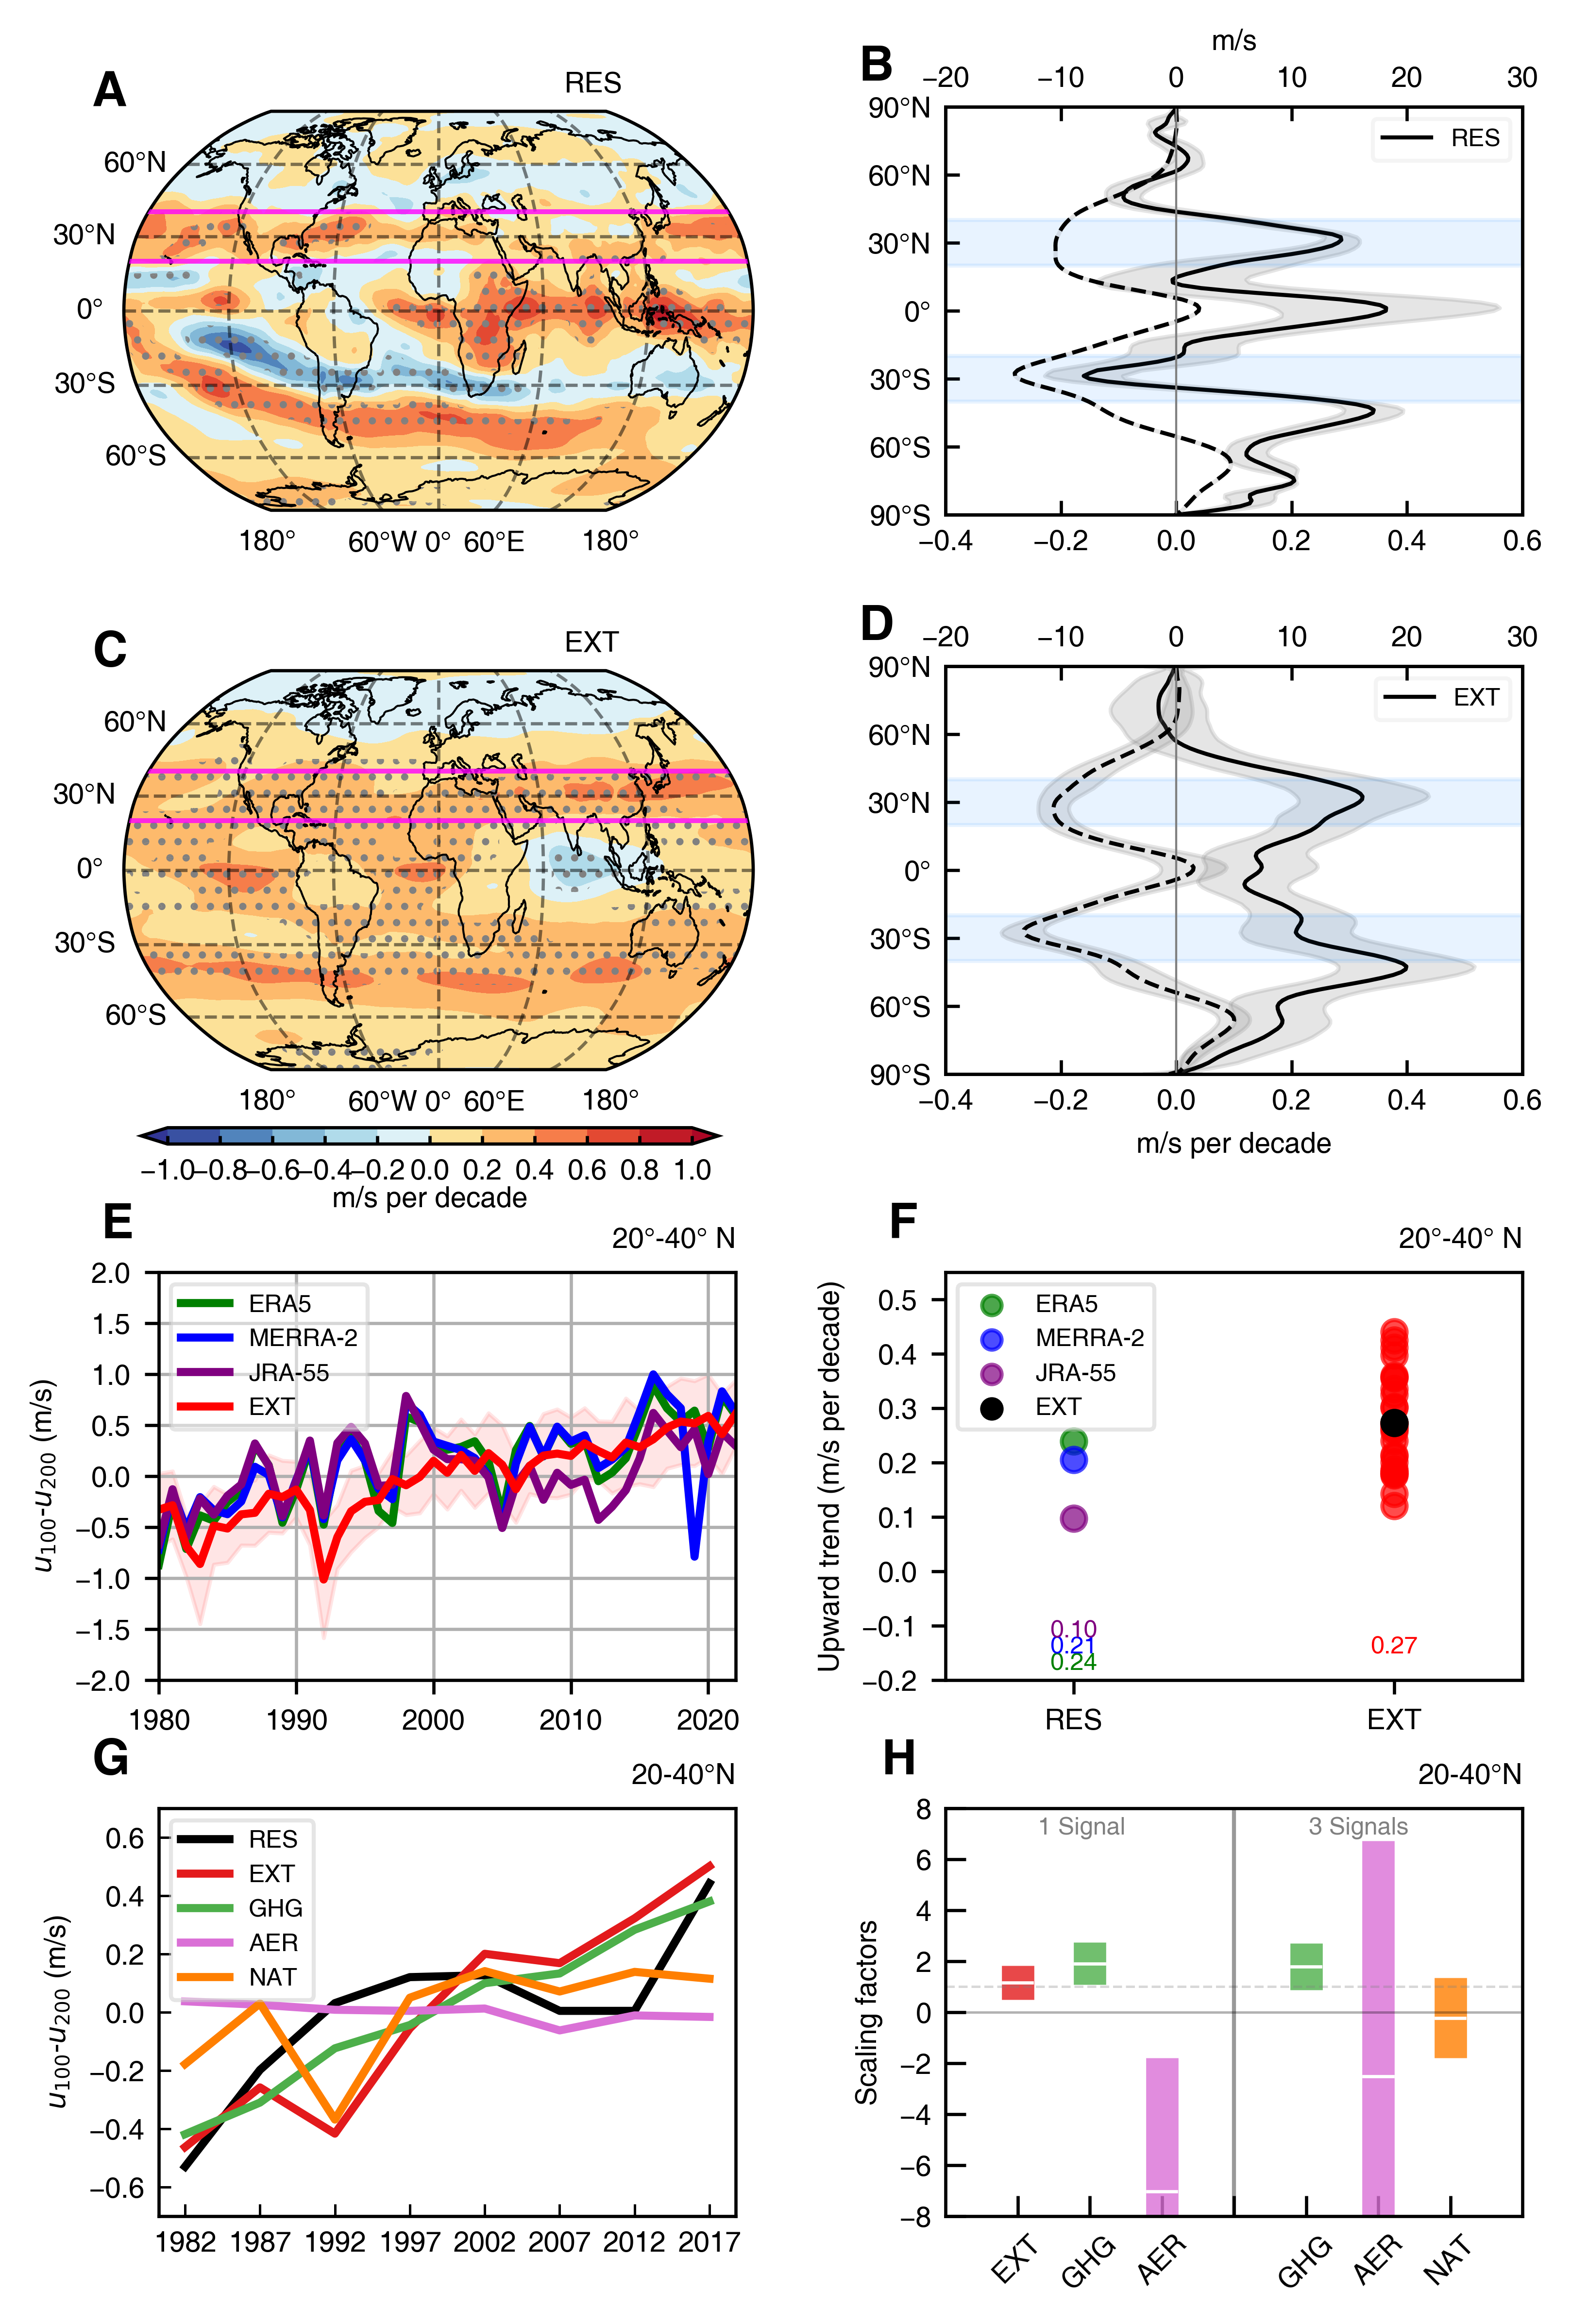

In [35]:
fig = plt.figure(figsize=(6,8),dpi=600)
leftlon, rightlon, lowerlat, upperlat = (-180, 181, -90, 90)
levels = np.linspace(-1, 1, 11)
levels2 = np.linspace(-20, 40, 7)
axes_list=[[0.08, 0.78, 0.36, 0.175],[0.55, 0.78, 0.33, 0.175],
           [0.08, 0.54, 0.36, 0.175],[0.55, 0.54, 0.33, 0.175],
           [0.1,0.28,0.33,0.175], [0.55,0.28,0.33,0.175],
           [0.1,0.05,0.33,0.175],[0.55,0.05,0.33,0.175]]

cf1 = plot_trend_and_significance(axes_list[0], ERA5_100minus200_361x181, (era5_trend_361x181+merra2_trend_361x181+jra55_trend_361x181)/3 * 120, 'u$_{100}$ - u$_{200}$', 'A', 'RES', levels, levels2, ccmap,p_values=obsmme_p_values_361x181,hzl=True)#p_values=era5_p_values,

cf4 = plot_trend_and_significance_ssp(axes_list[2],
                                      ssp585[0], h_ssp585_trend * 120, h_ssp585_p_values,
                                      r'$u_{100}$-$u_{200}$', 'C', 'EXT', levels, levels2, ccmap,
                                      hzl=True)
# 添加子图并调整大小
ax5 = fig.add_axes(axes_list[1])  # 调整这些数字以改变大小和位置
ax5_ = ax5.twiny()
ax6 = fig.add_axes(axes_list[3])  # 调整这些数字以改变大小和位置
ax6_ = ax6.twiny()
# ax34.set_xlabel('upward trend (m·s$^{-1}$·decade$^{-1}$)')
# 绘制子图
plot_zonmean_diff(ax6, h_ssp585_trend_zonmean * 120, h_ssp585_trend_zonmean_std,'-', ssp585.lat, r'$u_{100}$-$u_{200}$',
                  'D',(-0.4, 0.6))
ax6.set_xticks(np.linspace(-.4, .6, 6))
plot_zonmean_diff(ax6_, np.nanmean(h_ssp585_climatology[1]-h_ssp585_climatology[0],1),
                  np.std(h_ssp585_climatology_zonmean_allmodels[:,1]-h_ssp585_climatology_zonmean_allmodels[:,0],axis=0),
                  '--', ssp585.lat, ' ',' ',(-20,30))
ax6_.set_xticks(np.linspace(-20, 30, 6))
ax6.set_xlabel('m/s per decade', fontsize=7)
ax6.legend(['EXT'],fontsize=6,framealpha=0.2,loc='upper right')


###########绘制观测数据#################
era5_zonal_mean, era5_zonal_std = calculate_zonal_stats(era5_trend)
merra2_zonal_mean, merra2_zonal_std = calculate_zonal_stats(merra2_trend)
jra55_zonal_mean, jra55_zonal_std = calculate_zonal_stats(jra55_trend)

# 1. 统一到JRA55的145个纬度点
target_lats = JRA55_100minus200.g0_lat_2.values
#target_lats = ERA5_100minus200.lat.values
era5_zonal_mean = np.interp(target_lats, ERA5.lat.values, era5_zonal_mean)
merra2_zonal_mean = np.interp(target_lats, MERRA2.lat.values, merra2_zonal_mean)
era5_zonal_mean_clim = np.interp(target_lats, ERA5.lat.values, np.nanmean(ERA5_clim,1))
#era5_zonal_mean_clim = np.nanmean(ERA5_clim,1)
merra2_zonal_mean_clim = np.interp(target_lats, MERRA2.lat.values, np.nanmean(MERRA2_clim,1))
#jra55_zonal_mean_clim = np.interp(target_lats,JRA55.g0_lat_2.values,np.nanmean(JRA55_clim,1))
jra55_zonal_mean_clim = np.nanmean(JRA55_clim,1)
# 2. 合并成一个(3, 145)的数组，计算均值和标准差
all_data = np.stack([era5_zonal_mean, merra2_zonal_mean, jra55_zonal_mean], axis=0)
obs_zonal_mean_vals = np.mean(all_data, axis=0)
obs_zonal_mean_std_vals = np.std(all_data, axis=0)
all_data_clim = np.stack([era5_zonal_mean_clim, merra2_zonal_mean_clim, jra55_zonal_mean_clim], axis=0)
obs_zonal_mean_clim_vals = np.mean(all_data_clim, axis=0)
obs_zonal_mean_clim_std_vals = np.std(all_data_clim, axis=0)
# 3. 绘制集合平均
print(obs_zonal_mean_vals.shape)
print(obs_zonal_mean_std_vals.shape)
print(ERA5_100minus200.lat.shape)

plot_zonmean_diff(ax5, obs_zonal_mean_vals * 120, obs_zonal_mean_std_vals* 120,'-', JRA55.g0_lat_2, r'$u_{100}$-$u_{200}$','B',(-0.4, 0.6))
plot_zonmean_diff(ax5_, obs_zonal_mean_clim_vals,
                  np.zeros_like(obs_zonal_mean_clim_std_vals),
                  '--', JRA55.g0_lat_2, ' ',' ',(-20,30))

ax5.set_xticks(np.linspace(-.4, .6, 6))
ax5_.set_xticks(np.linspace(-20, 30, 6))
ax5_.set_xlabel('m/s', fontsize=7)
ax5.legend(['RES'],fontsize=6,framealpha=0.2,loc='upper right')





ERA5N = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/u_ERA5_197901-202212_areamean_N_100_200hPa.nc').u[1:,:,0,0]
MERRA2N = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/u_MERRA-2_198001-202212_areamean_N_100_200hPa.nc').U[:,:,0,0]
JRA55N = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/u_JRA-55_197901-202212_areamean_N_100_200hPa.nc').UGRD_GDS0_ISBL_S123[1:,:,0,0]
amipN = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/AMIP_AMIPFuture4K_AMIP4xCO2/ua_amip_all_models_197901-201412_yearmean_areamean_100_200hPa_N.nc').ua[:,:,:,0,0]# 原文件名为all_models9

ERA5_100minus200N = ERA5N[:,0]-ERA5N[:,1]
MERRA2_100minus200N = MERRA2N[:,1]-MERRA2N[:,0]
JRA55_100minus200N = JRA55N[:,0]-JRA55N[:,1]
amip_100minus200N=amipN[:,:,1]-amipN[:,:,0]

ERA5S = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/ERA5/u_ERA5_197901-202212_areamean_S_100_200hPa.nc').u[1:,:,0,0]
MERRA2S = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/MERRA-2/u_MERRA-2_197901-202212_areamean_S_100_200hPa.nc').U[:,:,0,0]
JRA55S = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/obs-data/JRA-55/u_JRA-55_197901-202212_areamean_S_100_200hPa.nc').UGRD_GDS0_ISBL_S123[1:,:,0,0]
amipS = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/AMIP_AMIPFuture4K_AMIP4xCO2/ua_amip_all_models_197901-201412_yearmean_areamean_100_200hPa_S.nc').ua[:,:,:,0,0]

ERA5_100minus200S = ERA5S[:,0]-ERA5S[:,1]
MERRA2_100minus200S = MERRA2S[:,1]-MERRA2S[:,0]
JRA55_100minus200S = JRA55S[:,0]-JRA55S[:,1]
amip_100minus200S= amipS[:,:,1]-amipS[:,:,0]

#h_ssp585 = xr.open_dataset(r'/home/dongyl/Databank/h+ssp585/zonmean/ua_h+ssp585_all_models_1958-2022_zonmean.nc').ua[:,21:]
h_ssp585 = xr.open_dataset(r'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/h+ssp585/ua_h+ssp585_all_models_1979-2099_zonmean.nc').ua[:,1:46]
h_ssp585_100minus200=h_ssp585[:,:,11]-h_ssp585[:,:,9]
h_ssp585_100minus200_S = areamean.mask_am4D(h_ssp585_100minus200[:,:,slice(40,56)])
h_ssp585_100minus200_N = areamean.mask_am4D(h_ssp585_100minus200[:,:,slice(89,105)])
h_ssp585mme_100minus200=h_ssp585[:,:,11]-h_ssp585[:,:,9]
h_ssp585mme_100minus200= h_ssp585mme_100minus200.mean(axis=0)
h_ssp585mme_100minus200_S = areamean.mask_am(h_ssp585mme_100minus200[:,slice(40,56)])
h_ssp585mme_100minus200_N = areamean.mask_am(h_ssp585mme_100minus200[:,slice(89,105)])
trends_ssp585N, p_values_ssp585N = dyl.calculate_trend(h_ssp585_100minus200_N)
trends_ssp585S, p_values_ssp585S = dyl.calculate_trend(h_ssp585_100minus200_S)
mean_trend_ssp585N,_,_, mean_p_value_ssp585N,_ = linregress(np.arange(45),h_ssp585mme_100minus200_N)
mean_trend_ssp585S,_,_, mean_p_value_ssp585S,_ = linregress(np.arange(45),h_ssp585mme_100minus200_S)

# Calculate the trends for each model and observational data
trends_ERA5N,_,_,p_value_ERA5N,_ = linregress(np.arange(43), ERA5_100minus200N)
trends_MERRA2N,_,_,p_value_MERRA2N,_ = linregress(np.arange(43), MERRA2_100minus200N)
trends_JRA55N,_,_,p_value_JRA55N,_ = linregress(np.arange(43), JRA55_100minus200N)
trends_amipN, p_values_amipN = dyl.calculate_trend(amip_100minus200N)
mean_trend_amipN,_,_, mean_p_value_amipN,_ = linregress(np.arange(36),np.mean(amip_100minus200N,0))

trends_ERA5S,_,_,p_value_ERA5S,_ = linregress(np.arange(43), ERA5_100minus200S)
trends_MERRA2S,_,_,p_value_MERRA2S,_ = linregress(np.arange(43), MERRA2_100minus200S)
trends_JRA55S,_,_,p_value_JRA55S,_ = linregress(np.arange(43), JRA55_100minus200S)
trends_amipS, p_values_amipS = dyl.calculate_trend(amip_100minus200S)
mean_trend_amipS,_,_, mean_p_value_amipS,_ = linregress(np.arange(36),np.mean(amip_100minus200S,0))


# New subplot for trends
scenarios = ['RES','EXT']
x_pos = np.arange(len(scenarios))
obs_trends = [[trends_ERA5N*10, trends_MERRA2N*10, trends_JRA55N*10], [trends_ERA5S*10, trends_MERRA2S*10, trends_JRA55S*10]]
obs_p_values = [[p_value_ERA5N, p_value_MERRA2N, p_value_JRA55N], [p_value_ERA5S, p_value_MERRA2S, p_value_JRA55S]]
#all_trends = [trends_ssp585*120 + [mean_trend_ssp585*120], obs_trends]
# Plotting individual model and observation trends as scatter points
sequence = ['E', 'F','G', 'H']
obs_color=['green','blue','purple']
obs_label = ['ERA5', 'MERRA-2', 'JRA-55']
title = ['20°-40° N','20°-40° S']
# 计算扣除1979-2008 均值后的u100-u200
# 计算扣除1979-2008 均值后的u100-u200
h_ssp585_100minus200 = [h_ssp585_100minus200_N-h_ssp585_100minus200_N.mean(axis=1).broadcast_like(h_ssp585_100minus200_N),
                        h_ssp585_100minus200_S-h_ssp585_100minus200_S.mean(axis=1).broadcast_like(h_ssp585_100minus200_S)]

ERA5_100minus200 = [ERA5_100minus200N-ERA5_100minus200N[:30].mean(axis=0), ERA5_100minus200S-ERA5_100minus200S[:30].mean(axis=0)]
MERRA2_100minus200 = [MERRA2_100minus200N-MERRA2_100minus200N[:29].mean(axis=0), MERRA2_100minus200S-MERRA2_100minus200S[:29].mean(axis=0)]
JRA55_100minus200 = [JRA55_100minus200N-JRA55_100minus200N[:30].mean(axis=0), JRA55_100minus200S-JRA55_100minus200S[:30].mean(axis=0)]
amip_100minus200 = [amip_100minus200N-amip_100minus200N[:,:30].mean(axis=1).broadcast_like(amip_100minus200N),
                    amip_100minus200S-amip_100minus200S[:,:30].mean(axis=1).broadcast_like(amip_100minus200S)]
p_values_ssp585 = [p_values_ssp585N, p_values_ssp585S]
#p_values_ssp245 = [p_values_ssp245N, p_values_ssp245S]
p_values_amip = [p_values_amipN, p_values_amipS]
trends_ssp585 = [trends_ssp585N, trends_ssp585S]
#trends_ssp245 = [trends_ssp245N, trends_ssp245S]
trends_amip = [trends_amipN, trends_amipS]
mean_trend_ssp585 = [mean_trend_ssp585N*10, mean_trend_ssp585S*10]
#mean_trend_ssp245 = [mean_trend_ssp245N*10, mean_trend_ssp245S*10]
mean_trend_amip = [mean_trend_amipN*10, mean_trend_amipS*10]


# Original plot
# Plotting the model ensemble mean and observational data
for i in range (1):
    ax1 = fig.add_axes(axes_list[4])
    ax2 = fig.add_axes(axes_list[5])

    ax1.plot(np.arange(1980, 2023), ERA5_100minus200[i], label='ERA5', color='green', linewidth=2)
    ax1.plot(np.arange(1980, 2023), MERRA2_100minus200[i], label='MERRA-2', color='blue', linewidth=2)
    ax1.plot(np.arange(1980, 2023), JRA55_100minus200[i], label='JRA-55', color='purple', linewidth=2)
    ax1.plot(np.arange(1980, 2023), h_ssp585_100minus200[i][:, :43].mean(axis=0),
             label='EXT', color='red', linewidth=2)
    ax1.fill_between(np.arange(1980, 2023),
                     h_ssp585_100minus200[i][:, :43].mean(axis=0) + h_ssp585_100minus200[i][:, :44].std(axis=0),
                     h_ssp585_100minus200[i][:, :43].mean(axis=0) - h_ssp585_100minus200[i][:, :44].std(axis=0),
                     color='red', alpha=0.1)
    if i == 0:
        ax1.legend(fontsize=6,markerscale=0.4,framealpha=0.5, loc= 'upper left',frameon=True)
    ax1.set_xticks(np.linspace(1980, 2100, 13))
    ax1.margins(x=0)
    ax1.set_ylim((-2,2))
    ax1.set_yticks(np.arange(-2, 2.1, .5))
    #ax1.set_xlabel('Year', fontsize=7)
    ax1.set_ylabel(r'$u_{100}$-$u_{200}$ (m/s)', fontsize=7)
    ax1.tick_params(axis='both', direction='out',which='major', labelsize=7)
    ax1.set_title(title[i], loc='right', fontsize=7)
    ax1.grid(True)
    ax1.text(-0.1, 1.17, sequence[i*2], transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')

    for obs in range(3):
        if obs_p_values[i][obs] < 0.05:
            ax2.scatter(0, obs_trends[i][obs], color=obs_color[obs], label=obs_label[obs], alpha=0.7)
        else:
            ax2.scatter(0, obs_trends[i][obs], color='none', edgecolors=obs_color[obs], label=obs_label[obs], alpha=0.7)
    for model in range(28):
        if p_values_ssp585[i][model] < 0.05:
            ax2.scatter(1, trends_ssp585[i][model]*10, color='r', alpha=0.7)
        else:
            ax2.scatter(1, trends_ssp585[i][model] * 10, color='none', edgecolors='r', alpha=0.7)
    #axes[1].scatter(0, trends_ssp585[model], color='r',label='members', alpha=0.7)
    # Plotting ensemble mean trends as larger, distinct points
    ax2.scatter(1, mean_trend_ssp585[i], color='black', label='EXT', zorder=3)

    add_bar_labels('green', 0, -.19,obs_trends[i][0])
    add_bar_labels( 'blue', 0, -.16,obs_trends[i][1])
    add_bar_labels('purple', 0, -.13,obs_trends[i][2])
    add_bar_labels('r', 1, -.16, mean_trend_ssp585[i])

    # Setting subplot aesthetics
    ax2.set_xlim((-0.4,1.4))
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(scenarios)
    ax2.set_ylim((-0.15,0.55))
    ax2.set_yticks(np.arange(-0.2, 0.6, .1))
    ax2.set_ylabel('Upward trend (m/s per decade)', fontsize=7)
    ax2.tick_params(axis='y', direction='out',which='major', labelsize=7)
    ax2.tick_params(axis='x', direction='out',which='major', labelsize=7)
    ax2.set_title(title[i], loc='right', fontsize=7)
    ax2.text(-0.1, 1.17, sequence[i*2+1], transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    if i == 0:
        ax2.legend(fontsize=6, markerscale=0.8, framealpha=0.5, loc='upper left', frameon=True)
################################以上，绘制时间序列和模式间散点##########################################################################################
################################以下，绘制五年平均时间序列和检测归因结果##################################################################################

# 调整配色方案
signal_colors = {
    'ALL': '#E31A1C',  # 活力红
    'GHG': '#4DAF4A',   # 浅绿色
    'AER': '#DA70D6',  # 鲜艳紫
    'NAT': '#FF7F00'  # 亮黄色
}

file_path2 = '/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/fingerprint/1980-2019/obs_GHG_aer_nat_ens3run_20_40_N_1980-2019_5yrmean_anom.dat'
file_path1 = '/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/fingerprint/1980-2019/obssigall_20_40_N_1980-2019_5yrmean_anom.dat'
# 读取数据
with open(file_path1, 'r') as f:
    lines = f.readlines()
# 解析数据
Y = list(map(float, lines[0].strip().split()))
X_data_all = [list(map(float, line.strip().split())) for line in lines[1:]]

with open(file_path2, 'r') as f:
    lines = f.readlines()
# 解析数据
X_data_GHGaernat = [list(map(float, line.strip().split())) for line in lines[1:]]
X_data = X_data_all + X_data_GHGaernat

signal_names = ['ALL', 'GHG', 'AER','NAT']
# 将数据转为 DataFrame
# 生成时间序列
t = np.arange(1982, 2022, 5)
data = {'Year': t, 'RES': Y}
for i, x in enumerate(X_data):
    signal_name = signal_names[i] if i < len(signal_names) else f'X{i + 1}'
    data[signal_name] = x
df = pd.DataFrame(data)

plot_time_series(axe = fig.add_axes(axes_list[6]), df=df, signal_names = signal_names,
                     area="20-40°N", t = np.arange(1982, 2022, 5))

base_dir = "/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/fingerprint/1980-2019/"
data_files = ["obs_all_20_40_N_1980-2019_sf_RC",'obs_GHG_ens3run_20_40_N_1980-2019_sf_RC',
              'obs_aer_ens3run_20_40_N_1980-2019_sf_RC',
              "obs_GHG_aer_nat_ens3run_20_40_N_1980-2019_sf_RC"]
EOF_single = [2,4,2]
sf_all = []
for i in range(len(data_files)-1):
    file_path1 = os.path.join(base_dir, f"{data_files[i]}.csv")
    df1 = pd.read_csv(file_path1)
    sf_all.append(df1[df1['#EOF'] ==EOF_single[i]])

file_path2 = os.path.join(base_dir, f"{data_files[-1]}.csv")
df2 = pd.read_csv(file_path2)
sf_GHGaernat = df2[df2['#EOF'] == 4]
plot_combined_figure(axes = fig.add_axes(axes_list[7]),loc_x1=3, loc_x2=7, betaout1 = sf_all,
                     betaout2 = sf_GHGaernat, signal_names1=['ALL','GHG', 'AER'],
                     signal_names2= ['GHG','AER','NAT'], area= '20-40°N')

# 创建一个大的轴，然后将colorbar放在下方
cbar_ax = fig.add_axes([0.09, 0.51, 0.33, 0.007])  # 调整这些数字以改变colorbar的大小和位置
# 创建colorbar
cbar = plt.colorbar(cf1, cax=cbar_ax, orientation='horizontal', pad=0.08, aspect=50, shrink=0.7, extend='both')
cbar.ax.xaxis.set_major_locator(MultipleLocator(0.2))
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='both', which='major', direction='in', length=2, labelsize=7)
cbar.set_label(label='m/s per decade', fontsize=7,labelpad=0.15)


plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.1.RESEXTu100minus200trend_globalpattern_timeseries_noamip_and_fingerprint_1980-2022.png',format='png',dpi=300)
plt.savefig('/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.1.timeseries_noamip_and_fingerprint_1979-2022.svg',format='svg',dpi=300)
plt.show()